In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

import xml.etree.ElementTree as ET

# 1. Acquiring Data

In [ ]:
# download data from : https://archive.org/details/stackexchange
# under 7z find : ai.stackexchange.com.7z | cs.stackexchange.com.7z | datascience.stackexchange.com.7z | stats.stackexchange.com.7z
# after downloading the dataset extract 7z files using following code
!sudo apt-get install p7zip
!7z x '/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/data/ai.stackexchange.com.7z' -oai/
!7z x '/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/data/cs.stackexchange.com.7z' -ocs/
!7z x '/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/data/datascience.stackexchange.com.7z' -ods/
# !7z x '/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/data/math.stackexchange.com.7z' -omath/
!7z x '/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/data/stats.stackexchange.com.7z' -ostats/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
p7zip set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/AAIC C . se study - StackOverflow/data/                                                                         1 file, 17384449 bytes (17 MiB)

Extracting archive: /content/drive/My Drive/AAIC Course/Per

# 2. Minor processing to get final dataframe

In [ ]:
# Parsing XML files - Posts
root_ai = ET.parse('ai/Posts.xml').getroot()
root_cs = ET.parse('cs/Posts.xml').getroot()
root_ds = ET.parse('ds/Posts.xml').getroot()
# root_math = ET.parse('math/Posts.xml').getroot()
root_stats = ET.parse('stats/Posts.xml').getroot()

# Parsing XML files - Comments
root_ai_comments = ET.parse('ai/Comments.xml').getroot()
root_cs_comments = ET.parse('cs/Comments.xml').getroot()
root_ds_comments = ET.parse('ds/Comments.xml').getroot()
# root_math_comments = ET.parse('math/Comments.xml').getroot()
root_stats_comments = ET.parse('stats/Comments.xml').getroot()

In [ ]:
# 1. Creating 4 Dataframes out of 4 XML files
df_ai = pd.DataFrame([i.attrib for i in root_ai]).astype({'Id': int})
df_cs = pd.DataFrame([i.attrib for i in root_cs]).astype({'Id': int})
df_ds = pd.DataFrame([i.attrib for i in root_ds]).astype({'Id': int})
df_stats = pd.DataFrame([i.attrib for i in root_stats]).astype({'Id': int})

print('Total no. of datapoints:', len(df_ai) + len(df_cs) + len(df_ds) + len(df_stats))
print(df_ai.shape, df_cs.shape, df_ds.shape, df_stats.shape)

# Dataframes with comments
df_ai_comments = pd.DataFrame([i.attrib for i in root_ai_comments]).drop(['Id'], axis = 1).rename(columns = {'PostId': 'Id'})
df_cs_comments = pd.DataFrame([i.attrib for i in root_cs_comments]).drop(['Id'], axis = 1).rename(columns = {'PostId': 'Id'})
df_ds_comments = pd.DataFrame([i.attrib for i in root_ds_comments]).drop(['Id'], axis = 1).rename(columns = {'PostId': 'Id'})
df_stats_comments = pd.DataFrame([i.attrib for i in root_stats_comments]).drop(['Id'], axis = 1).rename(columns = {'PostId': 'Id'})

Total no. of datapoints: 446223
(13819, 21) (75776, 21) (47604, 21) (309024, 21)


# Observations:
  1. one post i.e., can have multiple comments, hence we need to merge all comments pointing towards same post.

In [ ]:
# 1. merging all the comments with same Id
df_ai_comments = df_ai_comments.groupby('Id')['Text'].apply(' '.join).reset_index().astype({'Id': int})
df_cs_comments = df_cs_comments.groupby('Id')['Text'].apply(' '.join).reset_index().astype({'Id': int})
df_ds_comments = df_ds_comments.groupby('Id')['Text'].apply(' '.join).reset_index().astype({'Id': int})
df_stats_comments = df_stats_comments.groupby('Id')['Text'].apply(' '.join).reset_index().astype({'Id': int})
df_ai_comments.head()

,Id,Text
0,10000,"Can you elaborate on how you ""cheated""? How di..."
1,10009,"""Internal nodes"" are all nodes other than leaf..."
2,10012,Thanks a lot for the reply. I went through the...
3,10018,"According to the Al Jazeera newschannel, Human..."
4,10019,Take a look at tesseract OCR. It doesn't do wh...


In [ ]:
# finalizing merging
df_ai = df_ai.merge(df_ai_comments, how = 'left', on = 'Id').rename(columns = {'Text': 'Comments'})
df_cs = df_cs.merge(df_cs_comments, how = 'left', on = 'Id').rename(columns = {'Text': 'Comments'})
df_ds = df_ds.merge(df_ds_comments, how = 'left', on = 'Id').rename(columns = {'Text': 'Comments'})
df_stats = df_stats.merge(df_stats_comments, how = 'left', on = 'Id').rename(columns = {'Text': 'Comments'})
del df_ai_comments, df_cs_comments, df_ds_comments, df_stats_comments, root_ai_comments, root_cs_comments, root_ds_comments, root_stats_comments

In [ ]:
# 2. Removing datapoints with missing 'Tags', 'Title', 'Body'
df_ai = df_ai.iloc[df_ai[['Tags', 'Title', 'Body']].dropna().index]
df_cs = df_cs.iloc[df_cs[['Tags', 'Title', 'Body']].dropna().index]
df_ds = df_ds.iloc[df_ds[['Tags', 'Title', 'Body']].dropna().index]
df_stats = df_stats.iloc[df_stats[['Tags', 'Title', 'Body']].dropna().index]

print('Total no. of datapoints:', len(df_ai) + len(df_cs) + len(df_ds) + len(df_stats))
df_ai.shape, df_cs.shape, df_ds.shape, df_stats.shape

Total no. of datapoints: 216788


((5805, 22), (34581, 22), (22414, 22), (153988, 22))

In [ ]:
# 3. Merging all dataFrames into one dataframe
df = pd.concat([df_ai, df_cs, df_ds, df_stats])
del df_ai, df_cs, df_ds, df_stats, root_ai, root_cs, root_ds, root_stats
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216788 entries, 0 to 309023
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Id                     216788 non-null  int64 
 1   PostTypeId             216788 non-null  object
 2   AcceptedAnswerId       75926 non-null   object
 3   CreationDate           216788 non-null  object
 4   Score                  216788 non-null  object
 5   ViewCount              216788 non-null  object
 6   Body                   216788 non-null  object
 7   OwnerUserId            213715 non-null  object
 8   LastEditorUserId       125869 non-null  object
 9   LastEditDate           128597 non-null  object
 10  LastActivityDate       216788 non-null  object
 11  Title                  216788 non-null  object
 12  Tags                   216788 non-null  object
 13  AnswerCount            216788 non-null  object
 14  CommentCount           216788 non-null  object
 15  

In [ ]:
# 4. Identifying useful columns for task at hand
print(df.columns)
useful_columns = ['Title', 'Body', 'Tags', 'CreationDate', 'LastActivityDate', 'Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'Comments']
df = df[useful_columns]

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ParentId', 'ClosedDate', 'LastEditorDisplayName',
       'OwnerDisplayName', 'CommunityOwnedDate', 'Comments'],
      dtype='object')


In [ ]:
# 5. Imputing 'FavoriteCount' missing values with 0
df['FavoriteCount'] = df['FavoriteCount'].fillna(0)
df['Comments'] = df['Comments'].fillna('')

In [ ]:
df = df.reset_index(drop = True)
df['index'] = np.arange(0, 216788)
df.head()

,Title,Body,Tags,CreationDate,LastActivityDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Comments,index
0,"What is ""backprop""?","<p>What does ""backprop"" mean? Is the ""backprop...",<neural-networks><backpropagation><terminology...,2016-08-02T15:39:14.947,2019-11-16T17:56:22.093,8,436,3,0,1,,0
1,How does noise affect generalization?,<p>Does increasing the noise in data help to i...,<neural-networks><machine-learning><statistica...,2016-08-02T15:40:20.623,2019-02-23T22:36:37.133,10,546,3,0,1,,1
2,How to find the optimal number of neurons per ...,"<p>When you're writing your algorithm, how do ...",<deep-network><search><neurons>,2016-08-02T15:41:22.020,2018-10-18T10:45:15.213,29,930,4,0,10,,2
3,How to program AI in Mindstorms,<p>I have a LEGO Mindstorms EV3 and I'm wonder...,<python><mindstorms>,2016-08-02T15:42:08.177,2018-10-18T10:44:51.623,-3,2692,2,4,0,What's your goal? What kind of bot? Have you r...,3
4,Are humans intelligent according to the defini...,<p>Given the following definition of an intell...,<philosophy><definitions><intelligent-agent>,2016-08-02T15:43:35.460,2019-06-15T18:29:55.520,7,204,2,0,1,,4


In [ ]:
# # 6. Converting 'CreationDate' to UNIX time format, so that we can use it for TimeBasedSplitting
# lst = df['CreationDate'].values
# df['clean_CreationDate'] = [string.replace('T', ' ').split('.')[0] for string in lst]
# df['UNIX_CreationDate'] = pd.to_datetime(df['clean_CreationDate']).astype(int)/10**9
# del df['clean_CreationDate']

In [ ]:
# # 7. Converting 'LastActivityDate' to UNIX time format
# lst = df['LastActivityDate'].values
# df['clean_LastActivityDate'] = [string.replace('T', ' ').split('.')[0] for string in lst]
# df['UNIX_LastActivityDate'] = pd.to_datetime(df['clean_LastActivityDate']).astype(int)/10**9
# del df['clean_LastActivityDate'], lst

# 3. EDA

In [ ]:
# 1. basics about dataset
print("Total no.of 'questions' or 'datapoints' in dataset :", df.shape[0])
print("Total no.of 'features' in dataset :", df.shape[1])

Total no.of 'questions' or 'datapoints' in dataset : 216788
Total no.of 'features' in dataset : 12


In [ ]:
# 2. features in dataset and checking for any missing values in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216788 entries, 0 to 216787
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Title             216788 non-null  object
 1   Body              216788 non-null  object
 2   Tags              216788 non-null  object
 3   CreationDate      216788 non-null  object
 4   LastActivityDate  216788 non-null  object
 5   Score             216788 non-null  object
 6   ViewCount         216788 non-null  object
 7   AnswerCount       216788 non-null  object
 8   CommentCount      216788 non-null  object
 9   FavoriteCount     216788 non-null  object
 10  Comments          216788 non-null  object
 11  index             216788 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 19.8+ MB


In [ ]:
# 3. find duplicate rows
df[df.duplicated()]

,Title,Body,Tags,CreationDate,LastActivityDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Comments,index


## 1. Tags

In [ ]:
# replacing '-' with '_' in tags column
df['Tags'] = df['Tags'].str.replace('-', '_')

In [ ]:
# Extracting all the tags and their count
import re
all_tags = df['Tags'].values
all_tags_lst = [re.findall('<.*?>', i) for i in all_tags]
val, cnt = np.unique([j for i in all_tags_lst for j in i], return_counts=True)
val_cnt_dict = dict(zip(val, cnt))

# 1. Basics - min, max, mean, median, quantiles
pd.DataFrame({'val': list(val_cnt_dict.values())}).describe()

,val
count,2723.000000
mean,232.217407
std,994.761978
min,1.000000
25%,8.000000
50%,32.000000
75%,126.000000
max,23636.000000


In [ ]:
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
# 2. Top 20 highly frequent tags and their count
sorted(val_cnt_dict.items(), key=lambda x: x[1], reverse=True)[:20]

[('<machine_learning>', 23636),
 ('<r>', 22855),
 ('<regression>', 21287),
 ('<time_series>', 11476),
 ('<algorithms>', 9231),
 ('<probability>', 8618),
 ('<classification>', 7497),
 ('<python>', 7310),
 ('<neural_networks>', 7209),
 ('<hypothesis_testing>', 6989),
 ('<distributions>', 6732),
 ('<self_study>', 6583),
 ('<deep_learning>', 5874),
 ('<bayesian>', 5620),
 ('<logistic>', 5584),
 ('<correlation>', 4912),
 ('<mathematical_statistics>', 4868),
 ('<statistical_significance>', 4548),
 ('<normal_distribution>', 4241),
 ('<clustering>', 4234)]

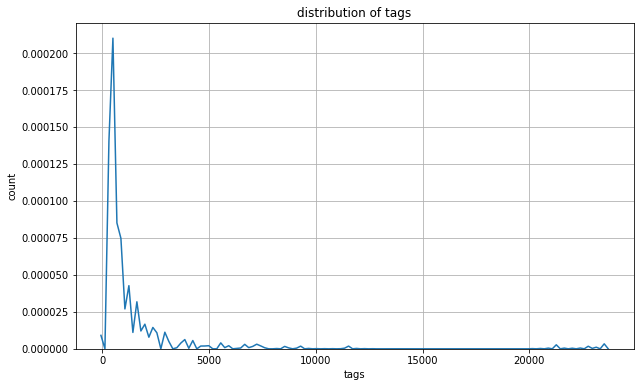

In [ ]:
# 3. distribution of tags
plt.figure(figsize = (10, 6))
sns.distplot(list(val_cnt_dict.values()),  hist= False)
plt.grid()
plt.title('distribution of tags')
plt.xlabel('tags')
plt.ylabel('count')
plt.show()

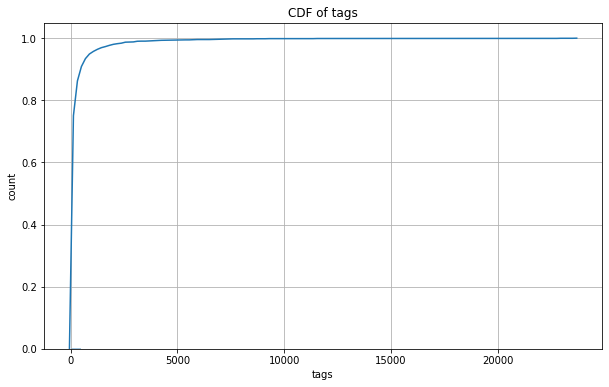

In [ ]:
# 4. CDF of tags
plt.figure(figsize = (10, 6))
kwargs = {'cumulative': True}
sns.distplot(list(val_cnt_dict.values()), kde_kws=kwargs)
plt.grid()
plt.title('CDF of tags')
plt.xlabel('tags')
plt.ylabel('count')
plt.show()

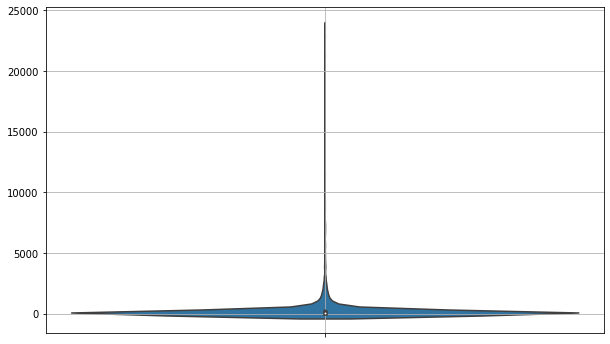

In [ ]:
# 6. violin_plot = distribuition + boxplot of tags
import seaborn as sns
plt.figure(figsize = (10, 6))
sns.violinplot(list(val_cnt_dict.values()), orient = 'v')
plt.grid()
plt.show()

<function matplotlib.pyplot.show>

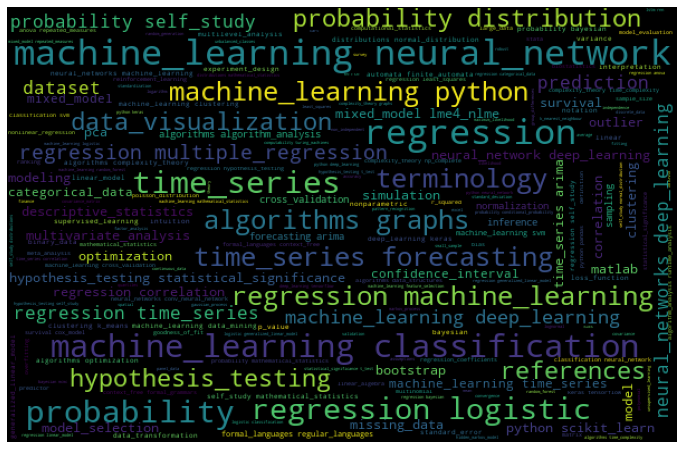

In [ ]:
# 7. visualizing frequency of tags through wordcloud
all_tags_lst  = [re.findall('<.*?>', i) for i in df['Tags']]
lst = []
for i in all_tags_lst:
  lst.append(' '.join(i))
string = ' '.join(lst)
  
from wordcloud import WordCloud
tag_wordcloud = WordCloud(width = 600, height = 400, repeat = False, max_font_size = 50).generate(string) 

plt.figure(figsize = (12, 8)) 
plt.imshow(tag_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.show

In [ ]:
# 8. checking frequency values between 99th to 100th percentile
lst = []
arr = list(val_cnt_dict.values())
for i in np.arange(99, 100.1, 0.1):
  lst.append(round(np.percentile(arr, i)))
  print(round(i, 3), round(np.percentile(arr, i)))

99.0 3043.0
99.1 3649.0
99.2 3891.0
99.3 4220.0
99.4 4762.0
99.5 5598.0
99.6 6600.0
99.7 7172.0
99.8 8120.0
99.9 14203.0
100.0 23636.0


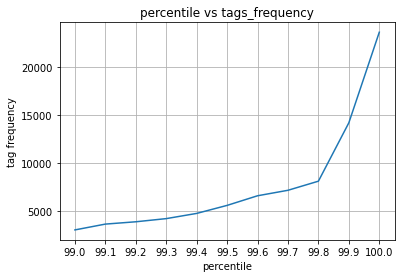

In [ ]:
# 8.1. graphical percentile method to identify inflation point
plt.plot(lst)
plt.grid()
plt.xticks(ticks = range(0, 11), labels = [round(i, 2) for i in np.arange(99,100.1,0.1)])
plt.title('percentile vs tags_frequency')
plt.xlabel('percentile')
plt.ylabel('tag frequency')
plt.show()

# Observations :
  1. mean value is 232 and median value is 32, It's really a huge gap between mean and median while both of them pointing towards central tendency of a random variable.
  2. This is not very healthy sign as far as machine learning prediction is concerned. We need to fine tune tags distribution so that frequency of each tag in the dataset can put some value in the tag prediction task.
  3. Again, Distribution plot (PDF) of tags is very skewed.
  4. Which implies there are very less no.of tags which are occurring very frequently.
  5. And, there are so many tags which are occurring very less times in the dataset.

# Conclusion :
  1. Some tags are ocurring only once or very few times in the dataset. Hence we need to remove those tags. since those tags would not be contributing any value in our machine learning task.
  2. As 99th percentile plot shows, some tags are having very high frequency. They will dominate in the tag prediction task. We will be removing those highly occurring tags too.
  

### 2. Text feature - 'Title'

In [ ]:
# Title token length
value = df['Title'].values
title_len = [len(i.split(' ')) for i in value]

# 1. basics
pd.DataFrame({'title_len' : title_len}).describe()

,title_len
count,216788.000000
mean,9.051350
std,4.054373
min,1.000000
25%,6.000000
50%,8.000000
75%,11.000000
max,35.000000


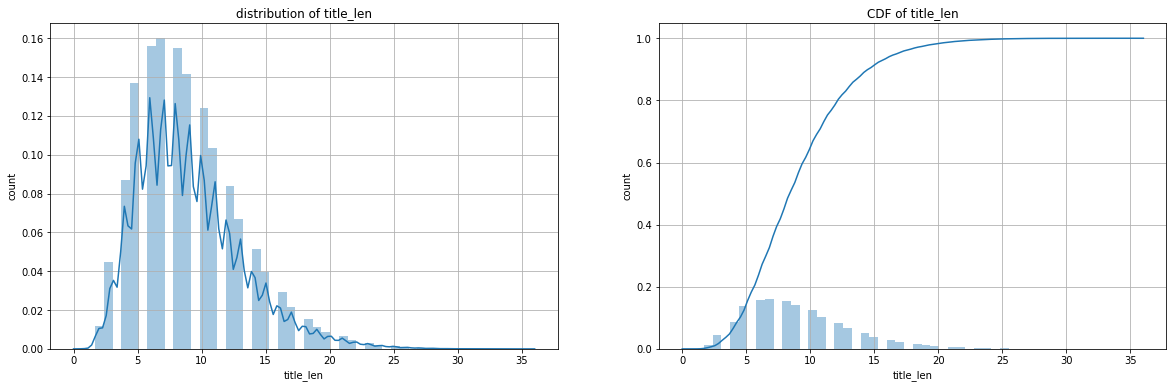

In [ ]:
# 2. plotting PDF and CDF of 'Title_length'
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
sns.distplot(title_len)
plt.grid()
plt.title('distribution of '+ 'title_len')
plt.xlabel('title_len')
plt.ylabel('count')

plt.subplot(1,2,2)
kwargs = {'cumulative': True}
sns.distplot(title_len, kde_kws=kwargs)
plt.grid()
plt.title('CDF of '+ 'title_len')
plt.xlabel('title_len')
plt.ylabel('count')
plt.show()

<function matplotlib.pyplot.show>

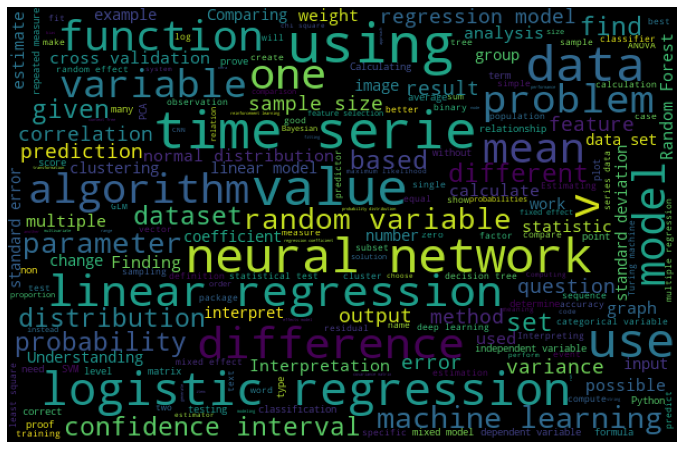

In [ ]:
# 3. plotting wordcloud for Title feature
string = ' '.join(df['Title'].values)
title_wordcloud = WordCloud(width = 600, height = 400, repeat = False, max_font_size = 50).generate(string)

plt.figure(figsize = (12, 8)) 
plt.imshow(title_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.show

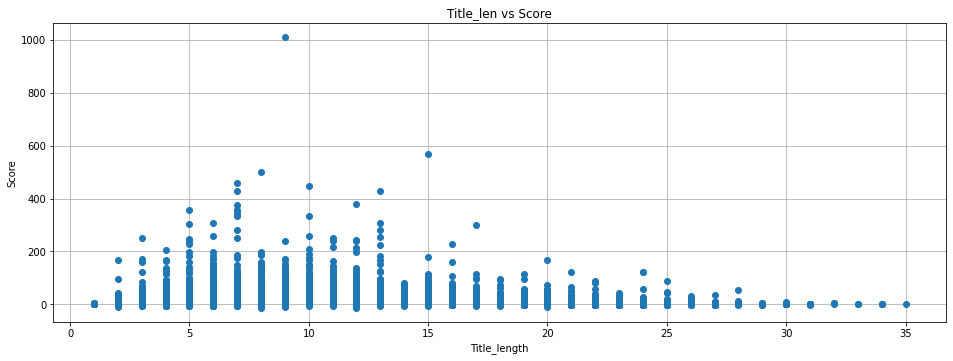

In [ ]:
# 4. Bivariate Analysis - Title_len vs Score
plt.figure(figsize = (16, 5.5))
plt.plot(title_len, df['Score'].astype(int).values, 'o')
plt.grid()
plt.xlabel('Title_length')
plt.ylabel('Score')
plt.title('Title_len vs Score')
plt.show()

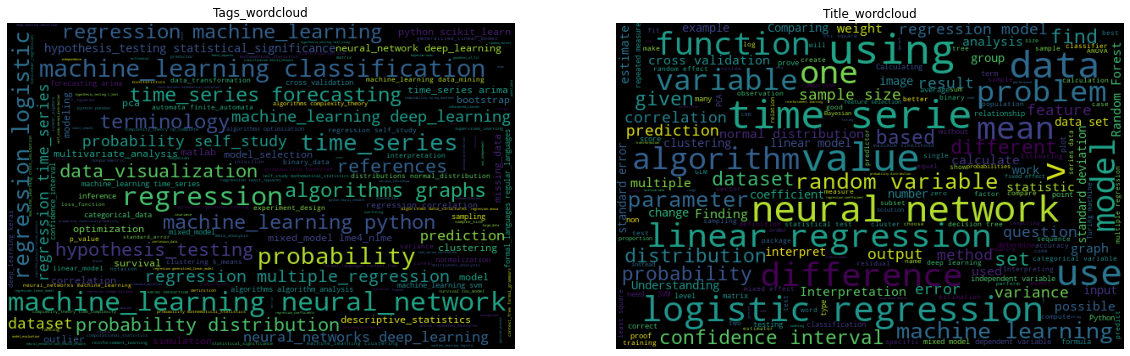

In [ ]:
# 5. Bivariate Analysis - comparison between top tags words and top title words
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
plt.imshow(tag_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.title('Tags_wordcloud')

plt.subplot(1,2,2)
plt.imshow(title_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.title('Title_wordcloud')
plt.show()

# Observations :
  1. Surprisingly without any text preprocessing, Title wordcloud has almost all the technical words than english language words. This suggests 'title' is very useful feature
  2. both wordclouds consisting so many similar words, which is again a healthy sign.
  3. Around 80% of the datapoints tend to have word_length of less than 12 words.

# Conclusion :
  1. So, we observed so many common terms between 'title' and 'tags', we can conclude that there must be very strong connection between 'title' and 'tags' Hence, we should use 'Title' feature to predict corrosponding 'tags'.

### 3. Text Feature : 'Body'

In [ ]:
# Title token length
value = df['Body'].values
body_len = [len(i.split(' ')) for i in value]

# 1. basics
pd.DataFrame({'body_len' : body_len}).describe()

,body_len
count,216788.000000
mean,177.714841
std,273.637153
min,1.000000
25%,73.000000
50%,122.000000
75%,203.000000
max,28627.000000


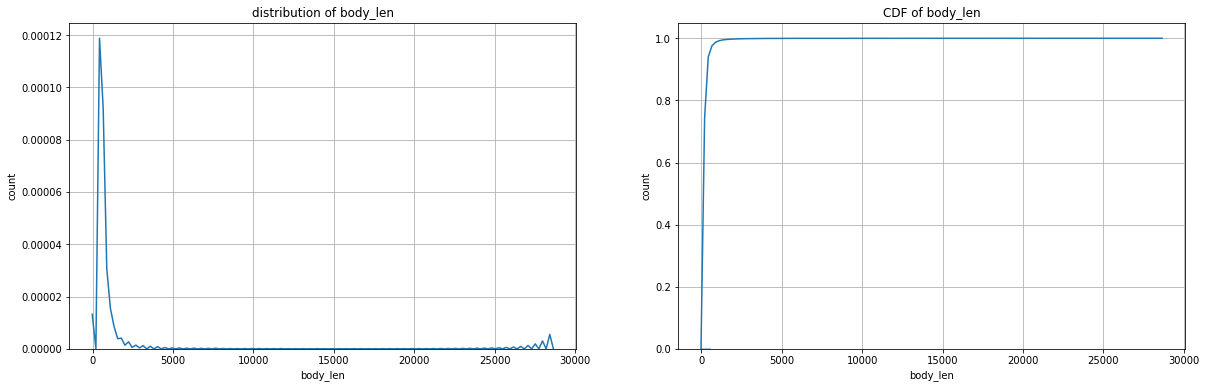

In [ ]:
# 2. plotting PDF and CDF of 'Body_length'
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
sns.distplot(body_len, hist = False)
plt.grid()
plt.title('distribution of '+ 'body_len')
plt.xlabel('body_len')
plt.ylabel('count')

plt.subplot(1,2,2)
kwargs = {'cumulative': True}
sns.distplot(body_len, kde_kws=kwargs)
plt.grid()
plt.title('CDF of '+ 'body_len')
plt.xlabel('body_len')
plt.ylabel('count')
plt.show()

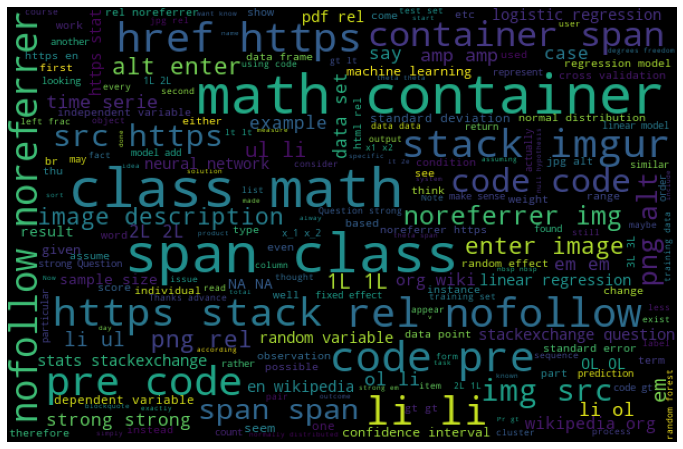

In [ ]:
# 3. plotting wordcloud for Title feature
string = ' '.join(df['Body'].values)
title_wordcloud = WordCloud(width = 600, height = 400, repeat = False, max_font_size = 50).generate(string)

plt.figure(figsize = (12, 8)) 
plt.imshow(title_wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.show()

# Observations : 
  1. From Wordcloud, its clear to see 'Body' feature has lots of html and web based keywords than computer_science specific terms. e.g., https, href, class, rel, nofollow, imgur, png, code, src etc.
  2. Almost 75% of the datapoints (questions) have word_count below 200 in its 'Body' feature.
# Conclusion : 
  1. We need to clean 'Body' feature such as removing external links, latex code etc.

### 4.  Datetime feature: "CreationDate"

In [ ]:
# 6. Converting 'CreationDate' to UNIX time format, so that we can use it for TimeBasedSplitting
lst = df['CreationDate'].values
df['clean_CreationDate'] = [string.replace('T', ' ').split('.')[0] for string in lst]
df['UNIX_CreationDate'] = pd.to_datetime(df['clean_CreationDate']).astype(int)/10**9
del df['clean_CreationDate']

In [ ]:
# some data massaging prior to dive deep into univariate EDA - extracting 'creation_year' feature 
datatime_lst = df['CreationDate'].values
datatime_lst = [string.replace('T', ' ').split('.')[0] for string in datatime_lst]
year = [int(i.split('-')[0]) for i in datatime_lst]

# 1. basics
pd.DataFrame({'year': year}).describe()

,year
count,216788.000000
mean,2016.323131
std,2.369666
min,2008.000000
25%,2015.000000
50%,2017.000000
75%,2018.000000
max,2020.000000


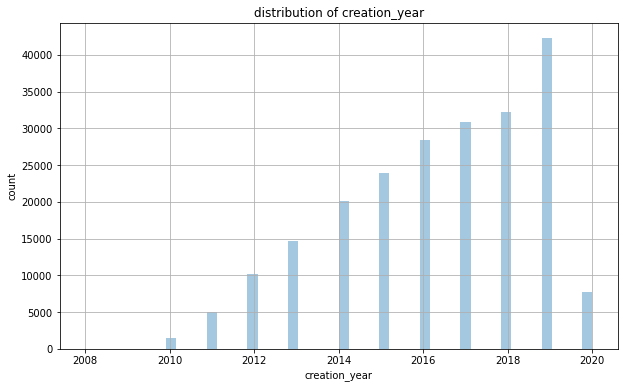

In [ ]:
# 2. Histogram of 'creation_year' feature
plt.figure(figsize = (10, 6))
sns.distplot(year, hist = True, kde = False)
plt.grid()
plt.title('distribution of '+ 'creation_year')
plt.xlabel('creation_year')
plt.ylabel('count')
plt.show()

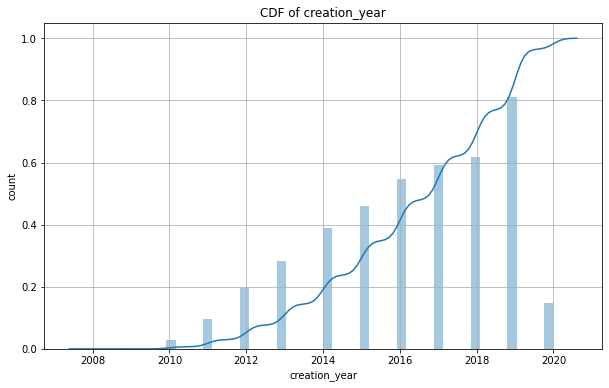

In [ ]:
# 3. CDF of 'creation_year' feature
plt.figure(figsize = (10, 6))
kwargs = {'cumulative': True}
sns.distplot(year, kde_kws=kwargs, hist = True)
plt.grid()
plt.title('CDF of '+ 'creation_year')
plt.xlabel('creation_year')
plt.ylabel('count')
plt.show()

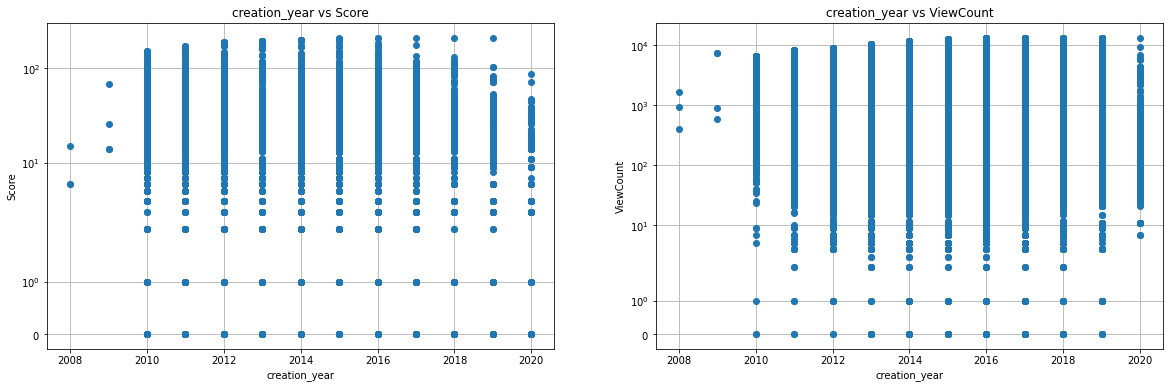

In [ ]:
# 4. simple Bivariate Analysis
# is there any relation between 'creation_year and Score'? OR
# is there any relation between 'creation_year and ViewCount'

plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
plt.plot(year, df['Score'], 'o')
plt.grid()
plt.title('creation_year vs Score')
plt.xlabel('creation_year')
plt.yscale('symlog')
plt.ylabel('Score')

plt.subplot(1,2,2)
plt.plot(year, df['ViewCount'], 'o')
plt.grid()
plt.title('creation_year vs ViewCount')
plt.xlabel('creation_year')
plt.yscale('symlog')
plt.ylabel('ViewCount')
plt.show()

# Observations:
  1. We have questions in the database from year 2008 to 2020.
  2. From Histogram of 'creation_year' feature, we can easily state that after 2010 'StackOverflow' has made linear growth in the upside direction. since no. of questions being asked on the platform are increasing each year.
  3. 80% of the questions asked prior to 2019, from 2008 to 2018.
  4. It is very important to note that, there is NO-relationship between 'creation_year' and 'Score' or 'creation_year' and 'ViewCounts', Because bivariate plot shows: 'Score' and 'Views' values are spread very similarly for all the 'years'.

# Conclusion :
  1. NO-relationship between 'creation_year' and 'Score' or 'creation_year' and 'ViewCounts', which implies community is NOT biased towards how old the question is.
  2. Above stated point is very healthy sign for Time Based Splitting, And hence we can go ahead with TBS for tag predictor model.

### 5. DateTime feature : 'LastActivityDate'



In [ ]:
# some data massaging prior to dive deep into univariate EDA - extracting 'LastActivityYear' feature 
datatime_lst = df['LastActivityDate'].values
datatime_lst = [string.replace('T', ' ').split('.')[0] for string in datatime_lst]
year = [int(i.split('-')[0]) for i in datatime_lst]

# 1. basics
pd.DataFrame({'year': year}).describe()

,year
count,216788.000000
mean,2016.872622
std,2.216645
min,2010.000000
25%,2015.000000
50%,2017.000000
75%,2019.000000
max,2020.000000


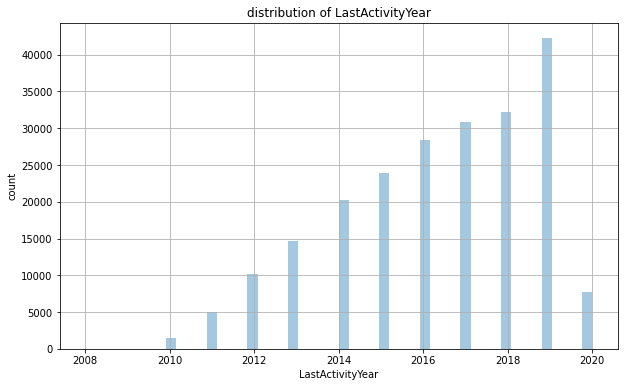

In [ ]:
# 2. Histogram of 'LastActivityYear' feature
plt.figure(figsize = (10, 6))
sns.distplot(year, hist = True, kde = False)
plt.grid()
plt.title('distribution of '+ 'LastActivityYear')
plt.xlabel('LastActivityYear')
plt.ylabel('count')
plt.show()

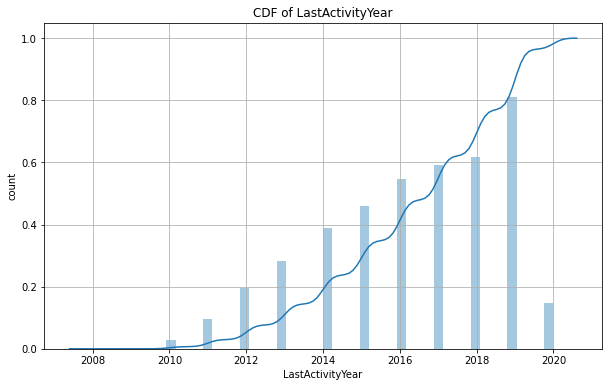

In [ ]:
# 3. CDF of 'LastActivityYear' feature
plt.figure(figsize = (10, 6))
kwargs = {'cumulative': True}
sns.distplot(year, kde_kws=kwargs, hist = True)
plt.grid()
plt.title('CDF of '+ 'LastActivityYear')
plt.xlabel('LastActivityYear')
plt.ylabel('count')
plt.show()

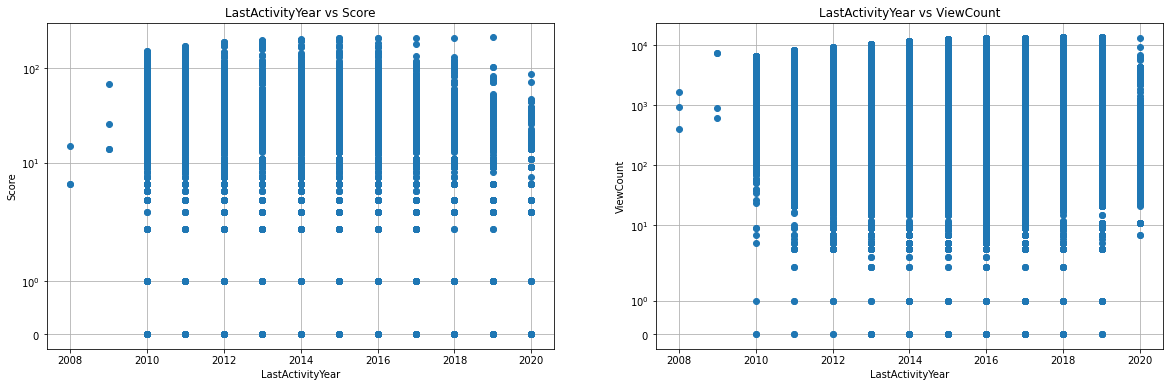

In [ ]:
# 4. simple Bivariate Analysis
# is there any relation between 'LastActivityYear and Score'? OR
# is there any relation between 'LastActivityYear and ViewCount'

plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
plt.plot(year, df['Score'], 'o')
plt.grid()
plt.title('LastActivityYear vs Score')
plt.xlabel('LastActivityYear')
plt.yscale('symlog')
plt.ylabel('Score')

plt.subplot(1,2,2)
plt.plot(year, df['ViewCount'], 'o')
plt.grid()
plt.title('LastActivityYear vs ViewCount')
plt.xlabel('LastActivityYear')
plt.yscale('symlog')
plt.ylabel('ViewCount')
plt.show()

# Observations:
  1. 'LastActivityYear' has very much similar EDA results with 'CreationYear' feature. 
  2. 'LastActivityYear' does not contribute any additional value or information into our system.

# Conclusion :
  1. Hence we are going to neglect this feature for our task.

### 6. Numerical feature : 'Score'

In [ ]:
# 1. Basics
df['Score'].astype(int).describe()

count    216788.000000
mean          2.632438
std           7.685406
min         -15.000000
25%           0.000000
50%           1.000000
75%           3.000000
max        1013.000000
Name: Score, dtype: float64

In [ ]:
def plot_pdf(column):
  """pass any column_name which consist of float or int from df"""
  plt.figure(figsize = (10, 6))
  sns.distplot(df[column].values, hist = False)
  plt.grid()
  plt.title('distribution of '+ column)
  plt.xlabel(column)
  plt.ylabel('count')
  plt.show()

In [ ]:
def plot_cdf(column):
  plt.figure(figsize = (10, 6))
  kwargs = {'cumulative': True}
  sns.distplot(df[column].values, kde_kws=kwargs, hist = False)
  plt.grid()
  plt.title('CDF of '+ column)
  plt.xlabel(column)
  plt.ylabel('count')
  plt.show()

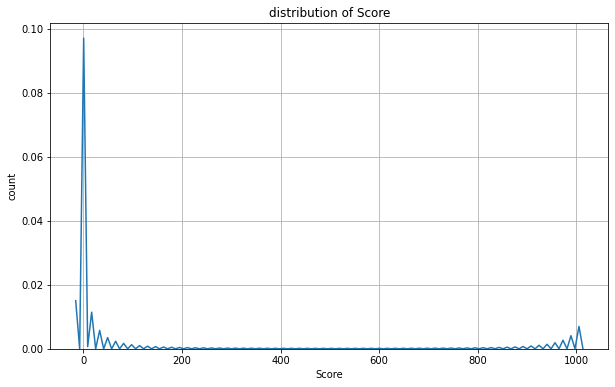

In [ ]:
# 2. distribution of tags
plot_pdf('Score')

In [ ]:
# 3. CDF of tags
# plot_cdf('Score')

In [ ]:
# 4. checking exact top frequency score
df['Score'].value_counts()[:10]

1     60807
0     56861
2     35039
3     19524
4     11678
5      7212
6      4702
7      3230
-1     2850
8      2421
Name: Score, dtype: int64

In [ ]:
# computing % of datapoints has not been scored with any value
dict(df['Score'].value_counts())['0']/df.shape[0]

0.26228850305367457

# Observations :
  1. Almost 26% of the datapoints has Score = 0
  2. Score values are distributed throughout the spectrum from min value = -15 to max value = 1013, since we are working on smaller chunk of datapoints as compare to production environment of 'StackOverflow' in realtime.
  3. Amongst,  Score = 1 has highest frequency. 0, 2, 3, 4 are subsequenct top scores.

# Conclusion : 
  1. Score is very important feature. We will be using this normalized weighted score for ranking of the results.
  2. There are some score values those have negative values. This will add more credibility in our ranking function. we will design a ranking function which can penalize those results with more weightage. 

### 7. CommentCount

In [ ]:
# 1. Basics
df['CommentCount'].astype(int).describe()

count    216788.000000
mean          2.008718
std           2.671741
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          52.000000
Name: CommentCount, dtype: float64

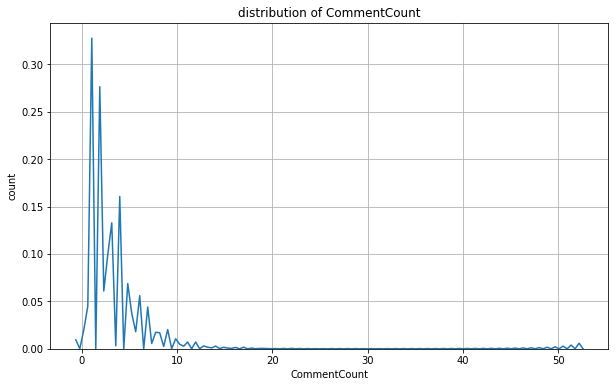

In [ ]:
# 2. distribution of tags
plot_pdf('CommentCount')

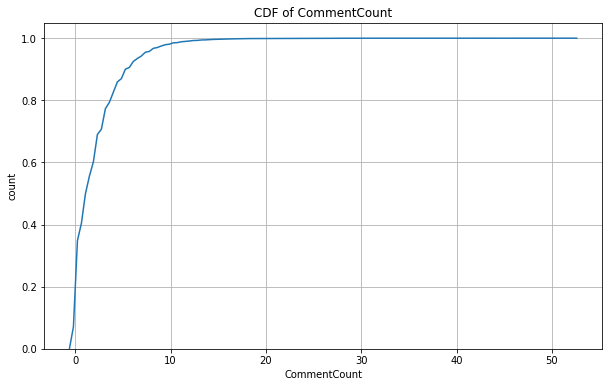

In [ ]:
# 3. CDF of CommentCount
plot_cdf('CommentCount')

In [ ]:
# 4. checking ecaxt top frequency AnswerCount
df['CommentCount'].astype(int).value_counts()[:10]

0    86233
1    34374
2    30531
3    20658
4    14684
5     9539
6     6596
7     4518
8     3069
9     2030
Name: CommentCount, dtype: int64

In [ ]:
# 5. computing % of datapoints has No comments
dict(df['CommentCount'].value_counts())['0']/df.shape[0]

0.39777570714246174

# Observations :
  1. Almost 40% of the questons has no comments.
  2. 80% of the datapoints tend to have less than or equal to 3 to 4 comments.

# Conclusion : 
  1. When 40% of datapoints do not have any comment, we cannot leverage the comment_count feature in our task.

### 8. ViewCount

In [ ]:
# 1. Basics
df['ViewCount'].astype(int).describe()

count    2.167880e+05
mean     1.510136e+03
std      8.844355e+03
min      2.000000e+00
25%      5.600000e+01
50%      1.740000e+02
75%      7.270000e+02
max      1.071331e+06
Name: ViewCount, dtype: float64

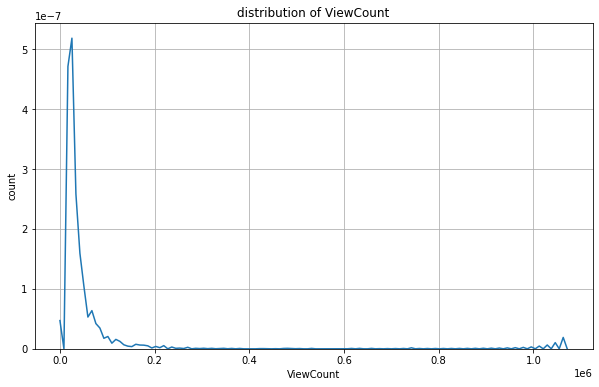

In [ ]:
# 2. distribution of ViewCount
plot_pdf('ViewCount')

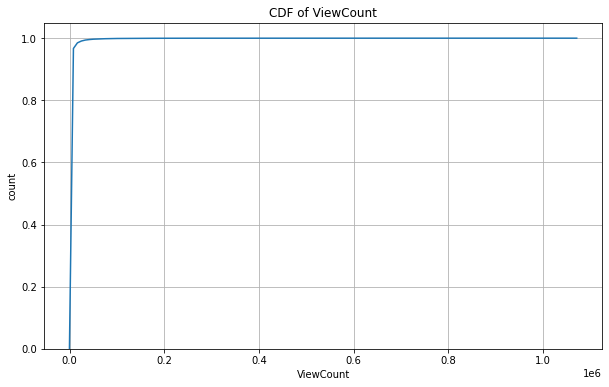

In [ ]:
# 3. CDF of ViewCount
plot_cdf('ViewCount')

In [ ]:
# # 4. checking exact top frequency ViewCount
df['ViewCount'].value_counts()[:10]

29    1390
30    1348
24    1342
32    1329
31    1327
28    1324
34    1323
25    1321
27    1319
33    1295
Name: ViewCount, dtype: int64

In [ ]:
# 5. Top 10 ViewCounts
sorted(df['ViewCount'].astype(int), reverse=True)[:10]

[1071331,
 1017650,
 744924,
 743447,
 660867,
 632871,
 614498,
 531819,
 501380,
 487462]

In [ ]:
# 6. computing % of datapoints has No 'ViewCount'
dict(df['ViewCount'].value_counts()).get('0', 0)/df.shape[0]

0.0

# Observations:
  1. ViewCount is spread all along the spectrum of values from 0 to million.
  2. mean = 1510 | mean value is not very trustworthy, since max_value = 1071331, And its ruining mean_value.
  3. Hence median comes in handy, median = 174. Roughly one can say that in general, people tend to view each question at 174 times.
  4. In our dataset, each question has viewed atleast twice.

### 9. AnswerCount

In [ ]:
# 1. Basics
df['AnswerCount'].astype(int).describe()

count    216788.000000
mean          1.036261
std           1.160516
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max         150.000000
Name: AnswerCount, dtype: float64

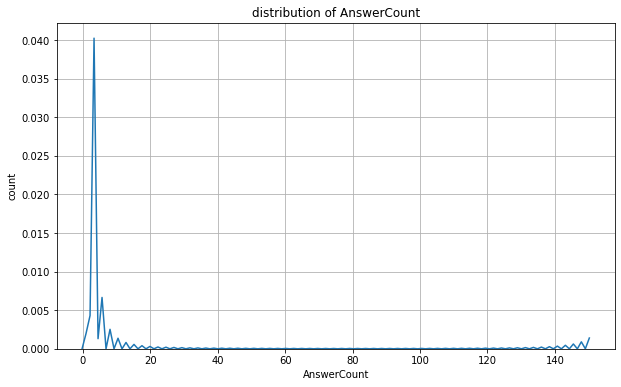

In [ ]:
# 2. distribution of AnswerCount
plot_pdf('AnswerCount')

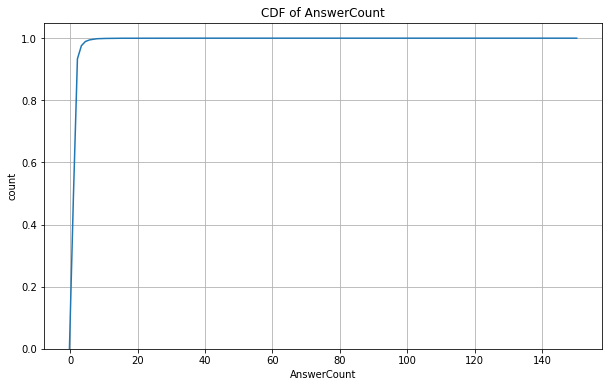

In [ ]:
# 3. CDF of AnswerCount
plot_cdf('AnswerCount')

In [ ]:
# 4. checking exact top frequency AnswerCount
df['AnswerCount'].value_counts()[:10]

1    105542
0     64706
2     32333
3      8986
4      2908
5      1074
6       473
7       264
8       146
9       106
Name: AnswerCount, dtype: int64

In [ ]:
# computing % of datapoints has No AnswerCount
dict(df['AnswerCount'].value_counts())['0']/df.shape[0]

0.2984759304020518

# Observations:
  1. almost 30% of the questions has not yet answered by anyone in the communinty.
  2. 80% datapoints has less than or equal to 2 to 3 answers.

# 4. Data  Preprocessing

In [ ]:
# Sample data_point, 
dp = 150000
df['Title'][dp], df['Tags'][dp], df['Body'][dp], df['Comments'][dp]

('Principal Component Analysis: how to interpret the total contribution of variables on several dimensions',
 '<pca><eigenvalues>',
 '<p>When we calculate the total contribution of a variable for a single dimension, the sum of all single contributions is equal to 100%, which makes perfect sense.</p>\n\n<p>The <a href="http://www.sthda.com" rel="nofollow noreferrer">http://www.sthda.com</a> suggests to calculate the total contribution of a variable for several dimensions multiplying single contributions to their eigenvalues, i.e.</p>\n\n<pre><code>(C1 * Eig1) + (C2 * Eig2) +...+ (Cn * Eign)\nwhere Eig - the eigenvalues\n</code></pre>\n\n<p>-the total sum of all contributions is more than 100%. See the example <a href="http://www.sthda.com/english/wiki/principal-component-analysis-how-to-reveal-the-most-important-variables-in-your-data-r-software-and-data-mining" rel="nofollow noreferrer">here</a> - chart "Contribution of variables to Dim 1-2":</p>\n\n<p><a href="https://i.stack.imgur.co

### 1. Multilabel data : 'Tags'

In [ ]:
# 1. replacing '-' with '_' in tags column
df['Tags'] = df['Tags'].str.replace('-', '_')

In [ ]:
# 2. Creating a Tags dataframe
all_tags = df['Tags'].values
all_tags_lst = [re.findall('<.*?>', i) for i in all_tags]
lst = [i + ['-']*(5-len(i)) if len(i) < 5 else i for i in all_tags_lst]
df_tags = pd.DataFrame(lst, columns = ['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5'])
df_tags['index'] = df['index']
df_tags.head()

,tag_1,tag_2,tag_3,tag_4,tag_5,index
0,<neural_networks>,<backpropagation>,<terminology>,<definitions>,-,0
1,<neural_networks>,<machine_learning>,<statistical_ai>,<generalization>,-,1
2,<deep_network>,<search>,<neurons>,-,-,2
3,<python>,<mindstorms>,-,-,-,3
4,<philosophy>,<definitions>,<intelligent_agent>,-,-,4


  ### Note - 
  * We've to remove highly frequent tags,
      1. To enhance the latency of search engine mechanism. 
      2. Highly frequent tags will dominate over less frequent tags in tag_predictor model.

  * At the end we've to check similarity between query and corpus of datapoints with same tags,
  
  * If tag belongs to 20K datapoints then it'll take way too long to compute similarity.

  * from EDA (99th to 100th percentile tags frequency plot) it seems that, upper_thre = 5000 and lower_thre = 200 are good values to experiment with.

In [ ]:
# 3. removing tags which has frequency below 200 and above 5000
# 3.1 Setting up threshold, and no.of tags remain after threshold setup
uppar_thre = 7000
lower_thre = 500
keep_tags_dict = {k:v for k, v in val_cnt_dict.items() if v > lower_thre and v < uppar_thre}
len(keep_tags_dict)

242

In [ ]:
# 3.2. remove all tags which are not in 'keep_tags_dict'
for col in df_tags.columns[:-1]:
  val = df_tags[col].values
  tag = [i if i in keep_tags_dict else '' for i in val]
  df_tags[col] = tag
df_tags = df_tags[(df_tags['tag_1'] != '') | (df_tags['tag_2'] != '') | (df_tags['tag_3'] != '') | (df_tags['tag_4'] != '') | (df_tags['tag_5'] != '')]
df_tags.head(2)

,tag_1,tag_2,tag_3,tag_4,tag_5,index
0,,<backpropagation>,<terminology>,,,0
6,,<terminology>,,,,6


In [ ]:
# 3.3. creating final df_tags dataframe
# joining all the tags again, to remove unnecessary 'spaces' or 'empty_strings'
keep_tags_lst = df_tags['tag_1'].str.cat(df_tags['tag_2']).str.cat(df_tags['tag_3']).str.cat(df_tags['tag_4']).str.cat(df_tags['tag_5']).tolist()

# splitting all tags
keep_tags_lst = [re.findall('<.*?>', i) for i in keep_tags_lst]

# maximum no.of tags one datapoint can have after removal of tags
print('maximum no.of tags one datapoint can have :', max([len(i) for i in keep_tags_lst]))

# creating a df_tags with cleaned tags
lst = [i + ['-']*(5-len(i)) if len(i) < 5 else i for i in keep_tags_lst]
df_tags[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5']] = lst
df_tags.head()

maximum no.of tags one datapoint can have : 5


,tag_1,tag_2,tag_3,tag_4,tag_5,index
0,<backpropagation>,<terminology>,-,-,-,0
6,<terminology>,-,-,-,-,6
9,<deep_learning>,<overfitting>,<regularization>,-,-,9
11,<overfitting>,<optimization>,-,-,-,11
13,<terminology>,-,-,-,-,13


In [ ]:
# 4. getting final df with preprocessed tags
df = df.iloc[df_tags.index]
df = df.join(df_tags, on = 'index', how = 'left', lsuffix = '_left')
# del df_tags
df.head(1)

,Title,Body,Tags,CreationDate,LastActivityDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Comments,index_left,tag_1,tag_2,tag_3,tag_4,tag_5,index
0,"What is ""backprop""?","<p>What does ""backprop"" mean? Is the ""backprop...",<neural_networks><backpropagation><terminology...,2016-08-02T15:39:14.947,2019-11-16T17:56:22.093,8,436,3,0,1,,0,<backpropagation>,<terminology>,-,-,-,0


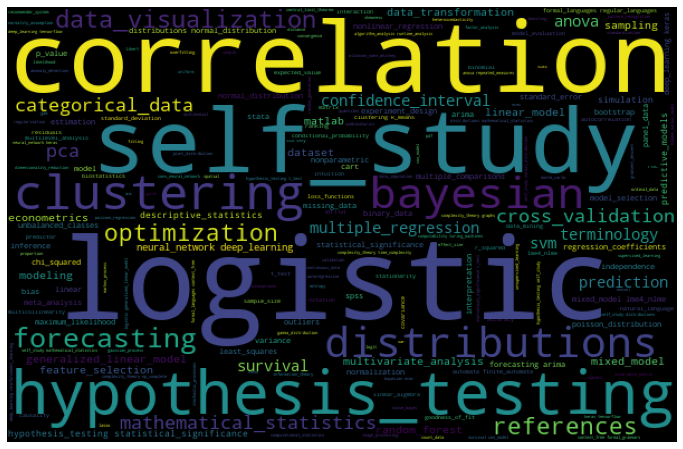

In [ ]:
# 5. distribution of tags after preprocessing
lst = df['tag_1'].str.cat(df['tag_2'], sep = ' ').str.cat(df['tag_3'], sep = ' ').str.cat(df['tag_4'], sep = ' ').str.cat(df['tag_5'], sep = ' ').tolist()
string = ''
for i in lst:
  string += i
  
from wordcloud import WordCloud
wordcloud = WordCloud(width = 600, height = 400,  
                stopwords = ['-'],
                ).generate(string) 

plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud, aspect = 'auto') 
plt.axis("off") 
plt.show()

In [ ]:
# no.of datapoints remain after removing some tags.
df.shape

(182083, 18)

# Observations :
  1. Wordcloud clearly states that, now there is nice distribution of tags than previous.
  

### 2. TEXT preprocessing - 'Title' + 'Body'

In [ ]:
# 1. creating new column : 'combined_text' by combining 'Title' and 'Body' together
title = df['Title'].values
body = df['Body'].values
lst =[]

for t, b in zip(title, body):
    lst.append(' '.join([t,b]))

del t, b
df['combined_text'] = lst
lst[:5]

['What is "backprop"? <p>What does "backprop" mean? Is the "backprop" term basically the same as "backpropagation" or does it have a different meaning?</p>\n',
 "What is fuzzy logic? <p>I'm new to A.I. and I'd like to know in simple words, what is the fuzzy logic concept? How does it help, and when is it used?</p>\n",
 'What is "early stopping" in machine learning? <p>What is <a href="https://en.wikipedia.org/wiki/Early_stopping" rel="nofollow noreferrer">early stopping</a> in machine learning and, in general, artificial intelligence? What are the advantages of using this method? How does it help exactly?</p>\n\n<p>I\'d be interested in perspectives and links to recent research.</p>\n',
 "What are the methods of optimizing overfitted models? <p>I'm worrying that my network has become too complex. I don't want to end up with half of the network doing nothing but just take up space and resources.</p>\n\n<p>So, what are the techniques for detecting and preventing overfitting to avoid such

 1. remove html tags, html urls, replace html comparison operators
 2. remove latex
 3. all lowercase 
 4. decontraction
 5. remove all special-characters
 6. Stop_word removal
 7. remove all white-space

In [ ]:
# defining a function to remove stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove('no'); stop_words.remove('not'); stop_words.remove('nor')

def stopwrd_removal(sent):
  lst = []
  for wrd in sent.split():
    if wrd not in stop_words:
      lst.append(wrd)
  return " ".join(lst)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_preprocessor(column):
  """pass any column with Text in it from df | Note: returns nothing makes inplace changes in df"""
  # 1. remove html tags, html urls, replace html comparison operators
  text = df[column].values
  df[column] = [re.sub('<.*?>', '', i) for i in text]
  df[column] = df[column].str.replace('&lt;', '<')\
                                          .str.replace('&gt;', '>')\
                                          .str.replace('&le;', '<=' )\
                                          .str.replace('&ge;', '>=')

  # 2. remove latex i,e., mostly formulas since it's mathematics based dataset
  df[column] = [re.sub('\$.*?\$', '', i) for i in text]

  # 3. all lowercase 
  df[column] = df[column].str.lower()

  # 4. decontractions
  df[column] = df[column].str.replace("won't", "will not").str.replace("can\'t", "can not").str.replace("n\'t", " not").str.replace("\'re", " are").str.\
                                                replace("\'s", " is").str.replace("\'d", " would").str.replace("\'ll", " will").str.\
                                                replace("\'t", " not").str.replace("\'ve", " have").str.replace("\'m", " am")

  # 5. remove all special-characters other than alpha-numericals
  df[column] = [re.sub('\W', ' ', i) for i in text]

  # # 6. Stop_word removal
  # df[column] = [stopwrd_removal(i) for i in text]

  # 7. remove all white-space i.e., \n, \t, and extra_spaces
  df[column] = df[column].str.replace("\n", " ").str.replace("\t", " ").str.rstrip()
  df[column] = [re.sub('  +', ' ', i) for i in text]

In [ ]:
text_preprocessor('combined_text')

##### sample datapoints after text_preprocessing

In [ ]:
text = df['Body'].values
print('TITLE : ', text[0:5], '\n')

text = df['combined_text'].values
print('COMBINED : ',text[0:5])

TITLE :  ['<p>What does "backprop" mean? Is the "backprop" term basically the same as "backpropagation" or does it have a different meaning?</p>\n'
 "<p>I'm new to A.I. and I'd like to know in simple words, what is the fuzzy logic concept? How does it help, and when is it used?</p>\n"
 '<p>What is <a href="https://en.wikipedia.org/wiki/Early_stopping" rel="nofollow noreferrer">early stopping</a> in machine learning and, in general, artificial intelligence? What are the advantages of using this method? How does it help exactly?</p>\n\n<p>I\'d be interested in perspectives and links to recent research.</p>\n'
 "<p>I'm worrying that my network has become too complex. I don't want to end up with half of the network doing nothing but just take up space and resources.</p>\n\n<p>So, what are the techniques for detecting and preventing overfitting to avoid such problems?</p>\n"
 '<p>Since human intelligence presumably is a function of a natural genetic algorithm in nature, is using a genetic a

# 5. Feature Engineering

### 1. # creating four new features - based on sentiment_polarity, sentiment_subjectivity using TextBlob
  - two for 'combined_text', two more for 'Comments'

#### Some Important notes:
  1. https://textblob.readthedocs.io/en/dev/quickstart.html
  2. The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity).
  3. The polarity score is a float within the range [-1.0, 1.0].
  4. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective

In [ ]:
# 1. defining setiment analyzer function 
from tqdm import tqdm
from textblob import TextBlob

def sentiment_fun(text):
  """Takes list of text and returns two list with 'polarity', 'subjectivity' scores"""
  sentiment_lst = []
  subjectivity_lst = []
  for i in tqdm(text):
    senti = TextBlob(i).sentiment
    sentiment_lst.append(senti[0])
    subjectivity_lst.append(senti[1])
  return sentiment_lst, subjectivity_lst

In [ ]:
# 2. computing sentiments for 'combined_text'
sentiment_lst, subjectivity_lst = sentiment_fun(text)
df['sentiment_comb'] = sentiment_lst
df['subjectivity_comb'] = subjectivity_lst

100%|██████████| 182083/182083 [04:32<00:00, 667.16it/s]


In [ ]:
# 3. computing sentiments based on 'Comments'
sentiment_lst, subjectivity_lst = sentiment_fun(df['Comments'].values)
df['sentiment_comments'] = sentiment_lst
df['subjectivity_comments'] = subjectivity_lst

100%|██████████| 182083/182083 [02:43<00:00, 1111.93it/s]


In [ ]:
# saving preprocessed dataframe to local disk
df.to_csv('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/df.csv', index = False)

# 6. Train_test_split - TimeBased : For tag_predictor model

In [ ]:
# 1. train_test split
train_set = 0.80
test_set = 1 - train_set

tbs_df = df.sort_values(by = ['UNIX_CreationDate'])
text_data_train = tbs_df['combined_text'].values[:int(df.shape[0]*train_set)]
text_data_test = tbs_df['combined_text'].values[-int(df.shape[0]*test_set):]

tags = tbs_df['tag_1'].str.cat(tbs_df['tag_2'], sep = ' ').str.cat(tbs_df['tag_3'], sep = ' ').str.cat(tbs_df['tag_4'], sep = ' ').str.cat(tbs_df['tag_5'], sep = ' ').tolist()
tags_train = np.array(tags[:int(df.shape[0]*train_set)])
tags_test = np.array(tags[-int(df.shape[0]*test_set):])

text_data_train.shape, text_data_test.shape, tags_train.shape, tags_test.shape

((145666,), (36416,), (145666,), (36416,))

In [ ]:
# 2. make sure all tags in test set are in train set
train_set_tags = np.array([i.split(' ') for i in tags_train])
test_set_tags = np.array([i.split(' ') for i in tags_test])

oob_tags = set(np.unique(test_set_tags)) - set(np.unique(train_set_tags))
len(oob_tags)

0

Text(0.5, 1.0, 'Distribution of test_tags')

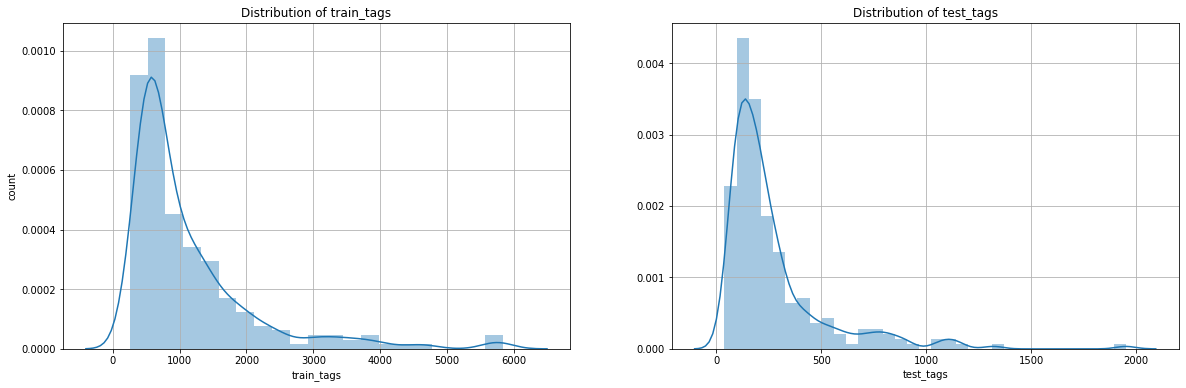

In [ ]:
# 3. checking distribution of train_tags compare to test_tags
# plot train_tags distribution
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
arr = np.array([j for i in train_set_tags for j in i])
tags, count = np.unique(arr, return_counts = True)
sns.distplot(count[1:])
plt.grid()
plt.xlabel('train_tags')
plt.ylabel('count')
plt.title('Distribution of train_tags')

# distribution of test_tags 
plt.subplot(1,2,2)
arr = np.array([j for i in test_set_tags for j in i])
tags, count = np.unique(arr, return_counts = True)
sns.distplot(count[1:])
plt.plot()
plt.grid()
plt.xlabel('test_tags')
plt.title('Distribution of test_tags')

In [ ]:
# 4. Top 10 tags from train_set
arr = np.array([j for i in train_set_tags for j in i])
tags, count = np.unique(arr, return_counts = True)
d = dict(zip(tags[1:], count[1:]))
sorted(d.items(), key = lambda x: x[1], reverse = True)[:10]

[('<hypothesis_testing>', 5838),
 ('<self_study>', 5744),
 ('<distributions>', 5666),
 ('<logistic>', 4716),
 ('<bayesian>', 4506),
 ('<correlation>', 4110),
 ('<deep_learning>', 3922),
 ('<statistical_significance>', 3763),
 ('<mathematical_statistics>', 3735),
 ('<normal_distribution>', 3521)]

In [ ]:
# 5. Top 10 tags from test_set
arr = np.array([j for i in test_set_tags for j in i])
tags, count = np.unique(arr, return_counts = True)
d = dict(zip(tags[1:], count[1:]))
sorted(d.items(), key = lambda x: x[1], reverse = True)[:10]

[('<deep_learning>', 1952),
 ('<keras>', 1320),
 ('<hypothesis_testing>', 1151),
 ('<mathematical_statistics>', 1133),
 ('<bayesian>', 1114),
 ('<neural_network>', 1067),
 ('<distributions>', 1066),
 ('<reinforcement_learning>', 917),
 ('<tensorflow>', 897),
 ('<logistic>', 868)]

## Notes:
  1. It's always important to check distribution of labels after splitting dataset into train and test. Otherwise model will fail on generalization accuracy.
  2. Here we're doing TimeBased splitting, since I think the nature of questions on the platform is changing over the period of time. Hence it seems best choice to split data.
  3. If we were doing random split then there would not be an issue of label stratification(i.e., almost equal dist of labels).

## Observations:
  1. There are no out_of_bag tags in test_set, i.e., a tag occurs in test_set but not in train_set.
  2. Distribution of train_tags and test_set is almost similar, It implies we're good going.
  3. Top tags_set of both sets are almost similar.